# Baie de Seine: compare different bathymetric products

- EMODNET: /home/ref-ocean-model-public/EMODNET_BATHY/2020/E4_2020.nc
- HOMONIM (SHOM): /home/datawork-lops-oc/BATHY/HOMONIM_2015/MNT_FACADE_ATLANTIQUE_HOMONIM_NM/DONNEES/MNT_ATL100m_HOMONIM_WGS84_NM_ZNEG.nc
- GEBCO2022
- Florent numerical model

HOMONIM and EMODNET seems to be those that have best resolution.

**!! There seem to be an offset between both bathymetry visually. This should be inspected more carefully ... but not time to do that at the moment :(**


In [1]:
import os
from glob import glob
from tqdm import tqdm

import numpy as np
import pandas as pd
import xarray as xr
#import hvplot.pandas  # noqa
import hvplot.xarray  # noqa

%matplotlib inline
import matplotlib.pyplot as plt

# 
import pynsitu as pin
crs = pin.maps.crs

----

## load datasets


In [2]:
root_dir = "/Users/aponte/Data/bathy"

In [3]:
# EMODNET

# store first a zoom
emod_file = os.path.join(root_dir, "baie_de_seine_emodnet/E4_2020_zoom.nc")

if False:
    ds = xr.open_dataset(os.path.join(root_dir, "baie_de_seine_emodnet/E4_2020.nc"))
    ds = ds.sel(lon=slice(-1.5,0.5), lat=slice(49.2, 49.8))
    #ds["cdi_reference"].encoding['dtype'] = 'S1'
    del ds["cdi_reference"].encoding['_FillValue']
    ds.to_netcdf(emod_file, mode="w")
else:
    ds = xr.open_dataset(emod_file)

print(ds.attrs["source"])
    
dlon, dlat = float(ds.lon.diff("lon").median()), float(ds.lat.diff("lat").median())    
print(f"dlon = {dlon:.4f}, dlat={dlat:.4f}")
print(f"dx = {dlon*np.cos(49/180*np.pi)*111e3:.0f} m, dy={dlon*111e3:.0f}")

b_emod = -ds.elevation.chunk("auto").rename("depth")
b_emod.attrs.update(dlon=dlon, dlat=dlat)

source of the data can be found in the dataset or in the documentation available from  http://www.emodnet-bathymetry.eu/
dlon = 0.0010, dlat=0.0010
dx = 76 m, dy=116


In [4]:
# homonim

homonim_file = os.path.join(root_dir, "baie_de_seine_homonim/zoom.nc")

if False:
    ds = xr.open_dataset(os.path.join(root_dir, "baie_de_seine_homonim/MNT_ATL100m_HOMONIM_WGS84_NM_ZNEG.nc"))
    ds = ds.rename(x="lon", y="lat")
    ds = ds.sel(lon=slice(-1.5,0.5), lat=slice(49.2, 49.8))

    ds.to_netcdf(homonim_file, mode="w")
else:
    ds = xr.open_dataset(homonim_file)

dlon, dlat = float(ds.lon.diff("lon").median()), float(ds.lat.diff("lat").median())
print(f"dlon = {dlon:.4f}, dlat={dlat:.4f}")
print(f"dx = {dlon*np.cos(49/180*np.pi)*111e3:.0f} m, dy={dlon*111e3:.0f}")

b_homonim = -ds.z.chunk("auto").rename("depth")
b_homonim.attrs.update(dlon=dlon, dlat=dlat)

dlon = 0.0010, dlat=0.0010
dx = 73 m, dy=111


In [5]:
# florent's simulation
model_file = os.path.join(root_dir, "baie_de_seine_model_Florent/bathy_CurviSeine_2010.nc")
ds = xr.open_dataset(model_file)

ds["longitude"] = ds.longitude.ffill("ni").bfill("ni").ffill("nj").bfill("nj")
ds["latitude"] = ds.latitude.ffill("ni").bfill("ni").ffill("nj").bfill("nj")

b_model = ds["H0"].rename("depth").assign_coords(lon=ds.longitude, lat=ds.latitude)
b_model = b_model.where(b_model>0)

In [6]:
# geboco22
gebco_file = os.path.join(root_dir, "baie_de_seine_gebco2022/gebco_2022_n50.5_s49.0_w-2.0_e1.0.nc")

ds = xr.open_dataset(gebco_file)
dlon, dlat = float(ds.lon.diff("lon").median()), float(ds.lat.diff("lat").median())    
print(f"dlon = {dlon:.4f}, dlat={dlat:.4f}")
print(f"dx = {dlon*np.cos(49/180*np.pi)*111e3:.0f} m, dy={dlon*111e3:.0f}")

b_gebco = ds.elevation.chunk("auto").rename("depth")
b_gebco = -b_gebco.where( b_gebco<=0 )
b_gebco.attrs.update(dlon=dlon, dlat=dlat)

dlon = 0.0042, dlat=0.0042
dx = 303 m, dy=462


---
## static plots

In [7]:
extent = [-1.5, 0.5, 49.2, 49.8]

def plot_map(depth, title):
    fig, ax, cbar = pin.maps.plot_map(None, extent, coastline="10m", land="10m", figsize=(15,5))
    depth.plot(ax=ax, transform=crs, vmin=0, vmax=70, zorder=100)
    dlon, dlat = depth.attrs["dlon"], depth.attrs["dlat"]
    ax.set_title(title+f"  dx = {dlon*np.cos(49/180*np.pi)*111e3:.0f} m, dy={dlat*111e3:.0f} m")

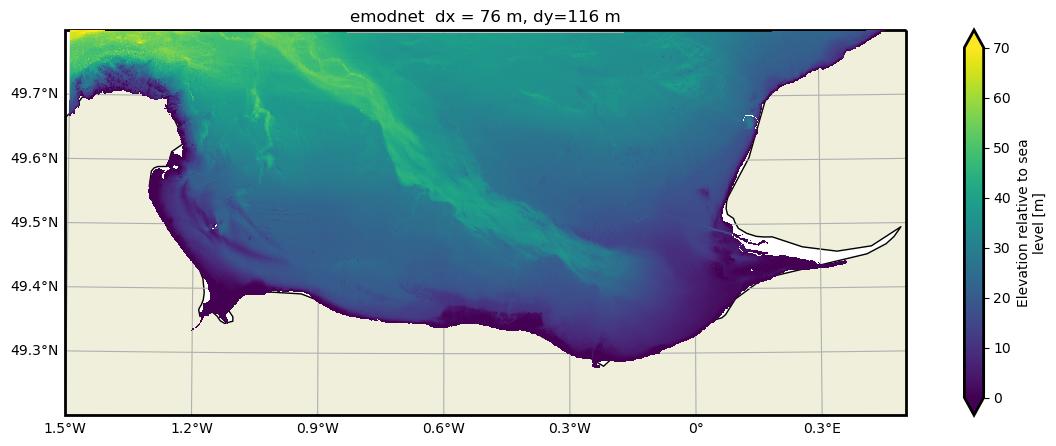

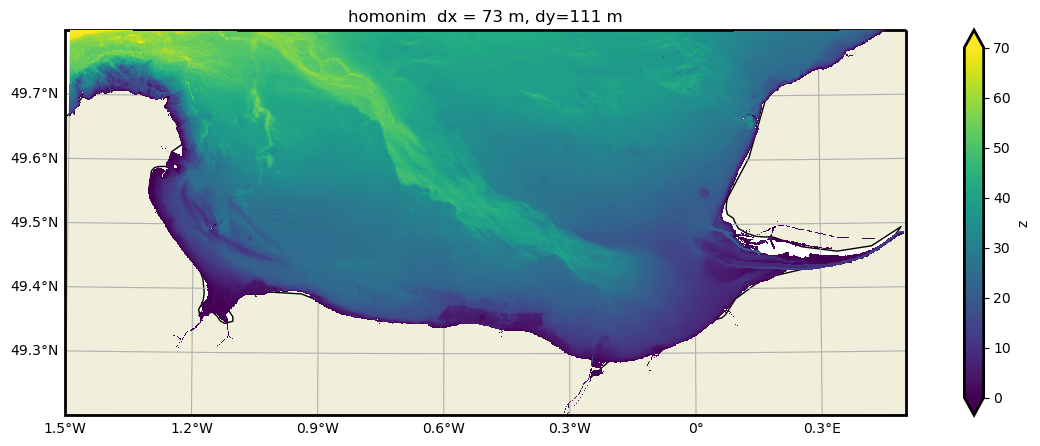

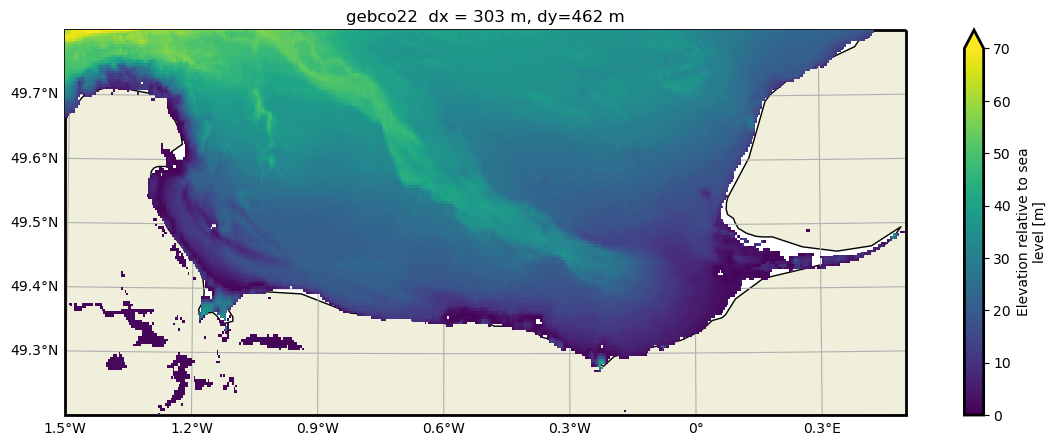

In [8]:
for depth, label in zip([b_emod, b_homonim, b_gebco], ["emodnet", "homonim", "gebco22"]):
    plot_map(depth, label)

Text(0.5, 1.0, 'model/florent')

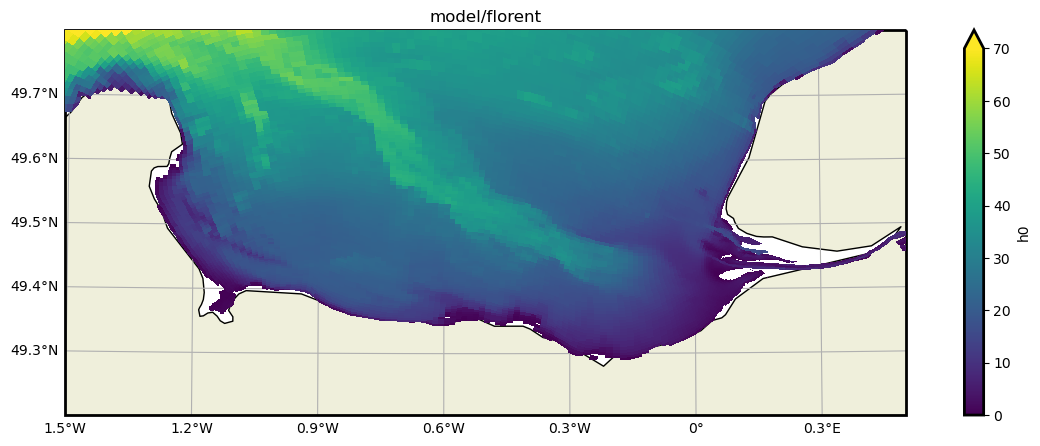

In [9]:
depth = b_model

fig, ax, cbar = pin.maps.plot_map(None, extent, coastline="10m", land="10m", figsize=(15,5))
depth.plot(
    x='lon', y='lat', ax=ax, transform=crs, vmin=0, vmax=70, zorder=100
)
ax.set_title("model/florent")

---
## dynamic plots

In [77]:
kw = dict(geo=True, rasterize=True, width=600, cmap="bgyw", clim=(0,70))
import geoviews.feature as gf
#coastlines = 
#feat = gf.land.options(scale='10m')
feat = gf.coastline.options(scale='10m')
# https://geoviews.org/user_guide/Geometries.html

In [ ]:
b_emod.hvplot(title="emodnet",**kw) * feat

In [ ]:
b_homonim.hvplot("lon", "lat", title="homonym", **kw) * feat

In [ ]:
b_gebco.hvplot(**kw, title="gebco22") * feat

In [ ]:
b_model.hvplot.quadmesh(
    'lon', 'lat', **kw    
)